In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount= True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import time
import sys
import os
import random
from skimage import io
import pandas as pd
from matplotlib import pyplot as plt
from shutil import copyfile

import cv2
from google.colab.patches import cv2_imshow

In [0]:
images_boxable = pd.read_csv('https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-images-boxable.csv')
images_boxable.head()

,image_name,image_url
0,e39871fd9fd74f55.jpg,https://requestor-proxy.figure-eight.com/figur...
1,f18b91585c4d3f3e.jpg,https://requestor-proxy.figure-eight.com/figur...
2,ede6e66b2fb59aab.jpg,https://requestor-proxy.figure-eight.com/figur...
3,ed600d57fcee4f94.jpg,https://requestor-proxy.figure-eight.com/figur...
4,ff47e649b23f446d.jpg,https://requestor-proxy.figure-eight.com/figur...


In [0]:
annotations_bbox = pd.read_csv('https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-annotations-bbox.csv')
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [0]:
class_descriptions = pd.read_csv('drive/My Drive/cohort/Dataset/Open Images Dataset v4 (Bounding Boxes)/class-descriptions-boxable.csv')
class_descriptions.head()

,name,class
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [0]:
Classes = ['Person','Stop sign','Traffic sign']

In [0]:
classes_pd = []
class_labels = []
class_bbox = []
class_imgID = []
sub_class_imgID = []
for class_name in  Classes:
    classes_pd.append( class_descriptions[class_descriptions['class'] == class_name])

print("Choosen Classes:\n")
for i in range(len(classes_pd)):
    print(classes_pd[i]['class'].values[0], end = '  :  ')
    print(classes_pd[i]['name'].values[0])
    class_labels.append(classes_pd[i]['name'].values[0])

Choosen Classes:

Person  :  /m/01g317
Stop sign  :  /m/02pv19
Traffic sign  :  /m/01mqdt


In [0]:
for i in range(len(class_labels)):
    class_bbox.append(annotations_bbox[annotations_bbox['LabelName']==class_labels[i]])
    class_imgID.append( np.unique(class_bbox[i]['ImageID']))
    
    print('There are %d images which contain ' % (len(class_imgID[i])),end = ' ')
    print(Classes[i], end = '\t')
    
    random.seed(1)
    random.shuffle(class_imgID[i])
    
    sub_class_imgID.append( class_imgID[i][0:2000])
    print('Choosing %d '% (len(sub_class_imgID[i])), end = '\n\n')


There are 248384 images which contain  Person	Choosing 2000 

There are 375 images which contain  Stop sign	Choosing 375 

There are 2817 images which contain  Traffic sign	Choosing 2000 



In [0]:
# Searching for URLs
sub_class_imgURL = []
sub_annotations_bbox = []
for i in range(len(Classes)):
    URLS = [images_boxable['image_url'][images_boxable['image_name']==name+'.jpg'].values for name in sub_class_imgID[i]]
    sub_class_imgURL.append(URLS)
    [sub_annotations_bbox.append( data ) for data in class_bbox[i]]

0d38657e9e419712
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/4ec6c0903971f4c4.jpg
(681, 1024, 3)


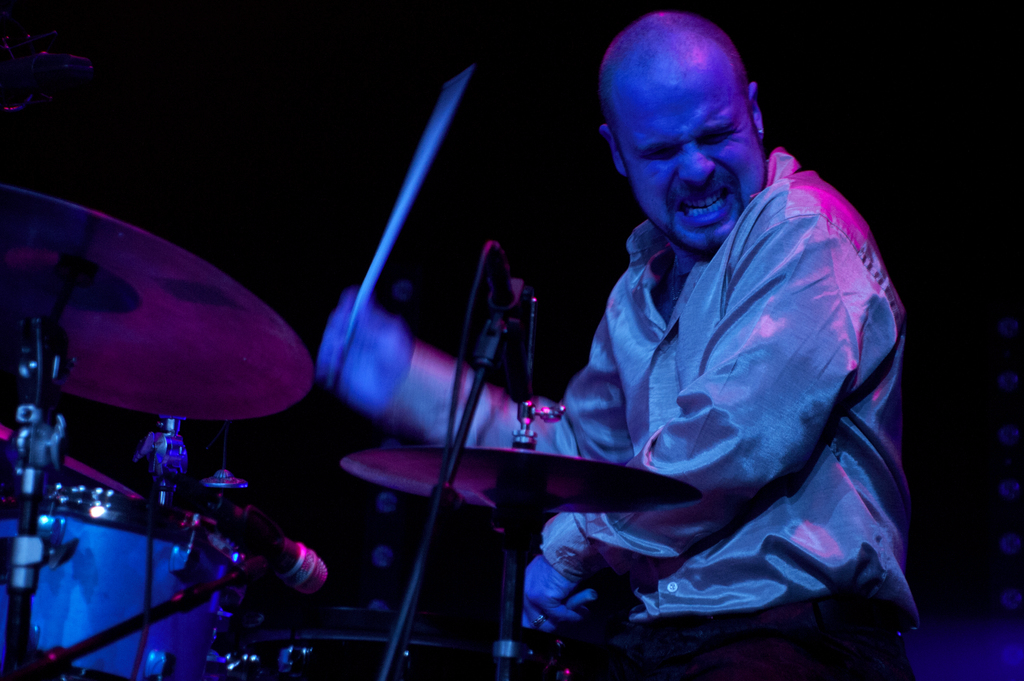

In [0]:
print(sub_class_imgID[0][10])
print(str(sub_class_imgURL[0][20])[2:-2])
img = io.imread(str(sub_class_imgURL[0][20])[2:-2])
print(img.shape)
cv2_imshow(img)

In [0]:
train_url ,train_ID = [] , []
test_url , test_ID = [] , []
for i in range(len(Classes)):
  [train_url.append(url) for url in sub_class_imgURL[i][ 0 : int(len(sub_class_imgURL[i])*0.8)]]
  [test_url.append(url)  for url in sub_class_imgURL[i][ int(len(sub_class_imgURL[i])*0.8) : ]]

  [train_ID.append(ID) for ID in sub_class_imgID[i][ 0 : int(len(sub_class_imgURL[i])*0.8)]]
  [test_ID.append(ID)  for ID in sub_class_imgID[i][ int(len(sub_class_imgURL[i])*0.8) : ]]

print('Total train images:',len(train_url))
print('Total test images:',len(test_url))
print(str(train_url[1])[2:-2])

Total train images: 3500
Total test images: 875
https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/5accc0a51f39559f.jpg


In [0]:
f= open('drive/My Drive/cohort/Dataset/Open Images Dataset v4 (Bounding Boxes)/annotation.txt',"w+")

for i in range(len(train_url)):
  img_id = train_ID[i]
  img_path = str(train_url[i])[2:-2]
  tmp_df = annotations_bbox[ annotations_bbox['ImageID'] == img_id]
  print(i)
  #img = io.imread(img_path)
  #(rows,cols) = img.shape[:2]
  for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for j in range(len(class_labels)):
          if labelName == class_labels[j]:
            f.write(img_path + ',' + str(float(row['XMin'])) + ',' + str(float(row['XMax'])) + ',' + str(float(row['YMin'])) + ',' + str(float(row['YMax'])) + ',' + Classes[j] + '\n')
  
f.close()



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(1024, 680, 3)
Traffic sign

(40, 53) (598, 606)


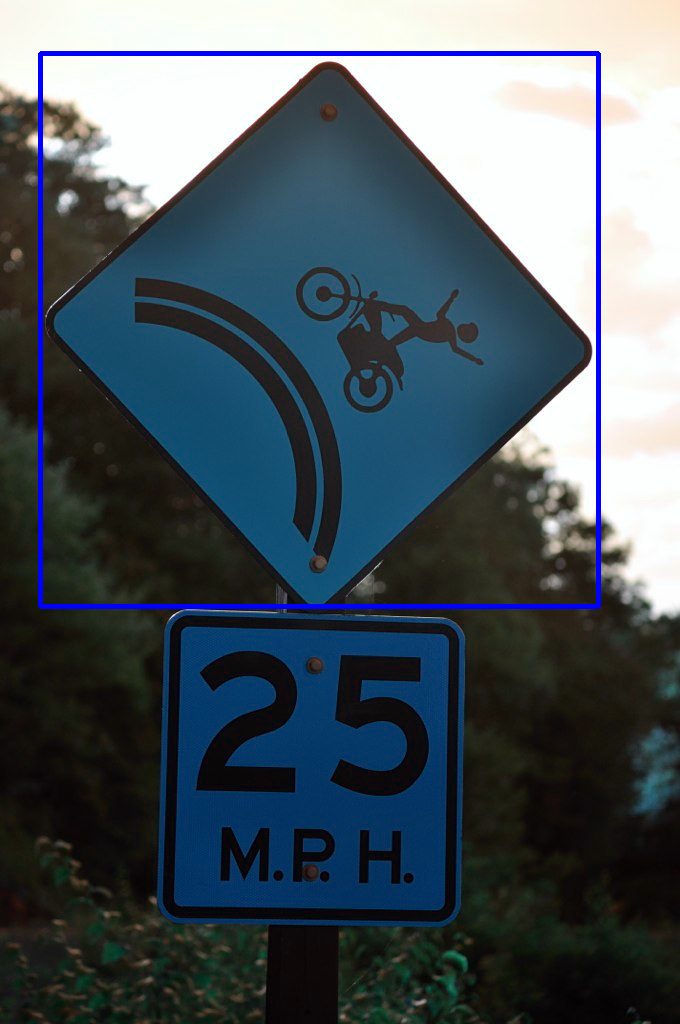

In [14]:
train_path =  'drive/My Drive/cohort/Dataset/Open Images Dataset v4 (Bounding Boxes)/annotation.txt'
f = open(train_path,'r')
i = 0
for line in f:
  if(i<9185):
    i+=1
    continue
  img_path , r_min , r_max , c_min , c_max , clas = line.split(',')
  
  img = io.imread(img_path)
  rows,cols = img.shape[0:2]
  print(img.shape)
  print(clas)
  print(( int(float(r_min)*cols) ,int(float(c_min)*rows)) , (int(float(r_max)*cols),int(float(c_max)*rows)) )
  cv2.rectangle(img , ( int(float(r_min)*cols) ,int(float(c_min)*rows)) , (int(float(r_max)*cols),int(float(c_max)*rows)) , (255,0,0) , 3 )
  cv2_imshow(img)
  
  break

In [0]:
f= open('drive/My Drive/cohort/Dataset/Open Images Dataset v4 (Bounding Boxes)/test_annotation.txt',"w+")

for i in range(len(test_url)):
  img_id = test_ID[i]
  img_path = str(test_url[i])[2:-2]
  tmp_df = annotations_bbox[ annotations_bbox['ImageID'] == img_id]
  print(i)
  #img = io.imread(img_path)
  #(rows,cols) = img.shape[:2]
  for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for j in range(len(class_labels)):
          if labelName == class_labels[j]:
            f.write(img_path + ',' + str(float(row['XMin'])) + ',' + str(float(row['XMax'])) + ',' + str(float(row['YMin'])) + ',' + str(float(row['YMax'])) + ',' + Classes[j] + '\n')
  
f.close()



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27